## Import Statements

In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import gridspec, rc
from matplotlib import ticker as mticker
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from numpy.random.mtrand import beta
from sklearn.preprocessing import normalize


from subpop import *
from learner_utils import *

%matplotlib inline

np.set_printoptions(precision=3, suppress=True)

In [2]:
## Plotting settings
rc('text', usetex = False)
rc('font', family = 'serif')
TITLE_SIZE = 13
LABEL_SIZE = 11
LEGEND_TITLE_SIZE = 12
LEGEND_SIZE = 11
TICK_SIZE = 11
FONT = 'serif'
params = {}
params['legend.title_fontsize'] = LEGEND_TITLE_SIZE
params['axes.labelsize'] = LABEL_SIZE
params['axes.titlesize'] = TITLE_SIZE
params['legend.fontsize'] = LEGEND_SIZE
params["xtick.labelsize"]= TICK_SIZE
params["ytick.labelsize"] = TICK_SIZE
params["font.family"] = "Times New Roman"
context = sns.plotting_context("paper", rc=params)
sns.set_theme(style="whitegrid", font=FONT)

## Dynamics Simulation

In [3]:
def run_experiment_with_prices(T, subpops, min_fn=quadratic_min, early_stop=False, verbose = True):
    n_learners = len(subpops[0].alphas)
    if verbose:
        print("Initial Conditions:")
        print(f"There are {n_learners} initial learners")
        print(f"Subpopulation splits: {[s.beta for s in subpops]}")
        print(f"Initial allocations: {[s.alphas for s in subpops]}")
        print(f"Optimal decisions theta for each subpop (row-wise) {[s.phi for s in subpops]}")
    average_risks_subpop = []
    average_risks_learner = []
    all_risks = []
    all_thetas = []
    all_alphas = []
    all_prices = []
    for t in range(T):
        if t == 0:
            prices = np.zeros(n_learners)
            thetas = np.array(learner_decisions(subpops, min_fn=min_fn))
        else:
            thetas, prices = learner_price_decisions(thetas, prices, subpops, min_fn=min_fn)
            thetas = np.array(thetas)
            prices = np.array(prices)
        print(f"t = {t}; Prices: {prices}")
        alpha = subpop_decisions(thetas, subpops, epsilon=0.1, prices=prices)
        #print(f"alphas: {alpha}")
        all_thetas.append(thetas)
        all_prices.append(prices)
        all_alphas.append(alpha.T)
        risks = get_all_risks(thetas, subpops)
        all_risks.append(risks)
        a_risk_subpop = average_risk_subpop(thetas, subpops, prices=prices)
        average_risks_subpop.append(a_risk_subpop)
        a_risk_learner = average_risk_learner(thetas, subpops)
        average_risks_learner.append(a_risk_learner)
        if early_stop:
            c_counts = convergent_count(subpops)
            if min(c_counts) > 20:
                break
    if verbose:
        print("Final Conditions:")
        print(f'\t\tLearners decisions: {thetas}')
        print(f'\t\tSubpopulation allocations: {alpha}')
    return(average_risks_subpop, average_risks_learner, all_risks, all_thetas, all_alphas, all_prices) 

## Figure 1: Risk profiles over time

In [5]:
def run_trial(allocation=None, min_fn = quadratic_min):
    T = 500
    # relative sizes
    beta_1 = 1
    beta_2 = 1 
    beta_3 = 1
    # initial allocations
    if allocation is  None:
        dist = np.array([[0.01, 0.02, -0.04], [-0.01,-0.01, 0.02]])
        dist = np.random.rand(2,3)*0.1
        alpha = np.array([[1,1, 1], [1,1, 1]]) + dist
        # alpha_ij <- fraction of subpop j going to learner i
        alpha =  normalize(alpha, axis=0, norm='l1')   
    else:
        alpha = allocation
    # optimal thetas for each subpop
    phi_1 = np.array([0, 1])
    phi_2 = np.array([1, 1])
    phi_3 = np.array([0.6, 0])
    # phi = np.array([phi_1, phi_2])

    pop1 = QuadraticSubPop(phi_1, beta_1, alpha[:,0], price_sensitivity=1)
    pop2 = QuadraticSubPop(phi_2, beta_2, alpha[:,1], price_sensitivity=1)
    pop3 = QuadraticSubPop(phi_3, beta_3, alpha[:,2], price_sensitivity=1)
    subpops = [pop1, pop2, pop3]

    # Run dynamics and create plots
    (average_risks_subpop, average_risks_learner, all_risks, all_thetas, all_alphas, all_prices) = run_experiment_with_prices(T, subpops, min_fn=min_fn, early_stop=False)
    
    return(average_risks_subpop, average_risks_learner, all_risks, all_thetas, all_alphas, all_prices)


In [6]:
allocations =  np.array([[0.496, 0.511, 0.498], [0.504, 0.489, 0.502]])
allocations = None
(average_risks_subpop, average_risks_learner, all_risks, all_thetas, all_alphas, all_prices) = run_trial(allocations, min_fn = quadratic_min)

Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial allocations: [array([0.503, 0.497]), array([0.492, 0.508]), array([0.496, 0.504])]
Optimal decisions theta for each subpop (row-wise) [array([0, 1]), array([1, 1]), array([0.6, 0. ])]
t = 0; Prices: [0. 0.]
t = 1; Prices: [0. 0.]
t = 2; Prices: [0. 0.]
t = 3; Prices: [0. 0.]
t = 4; Prices: [0. 0.]
t = 5; Prices: [0. 0.]
t = 6; Prices: [0. 0.]
t = 7; Prices: [0. 0.]
t = 8; Prices: [0. 0.]
t = 9; Prices: [0. 0.]
t = 10; Prices: [0. 0.]
t = 11; Prices: [0. 0.]
t = 12; Prices: [0. 0.]
t = 13; Prices: [0. 0.]
t = 14; Prices: [0. 0.]
t = 15; Prices: [0. 0.]
t = 16; Prices: [0. 0.]
t = 17; Prices: [0. 0.]
t = 18; Prices: [0. 0.]
t = 19; Prices: [0. 0.]
t = 20; Prices: [0. 0.]
t = 21; Prices: [0. 0.]
t = 22; Prices: [0. 0.]
t = 23; Prices: [0. 0.]
t = 24; Prices: [0. 0.]
t = 25; Prices: [0. 0.]
t = 26; Prices: [0. 0.]
t = 27; Prices: [0. 0.]
t = 28; Prices: [0. 0.]
t = 29; Prices: [0. 0.]
t = 30; Prices: [

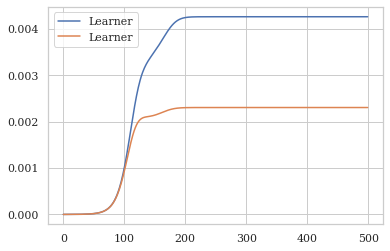

In [7]:
plt.plot(range(len(all_prices)), all_prices, label="Learner")
plt.legend()

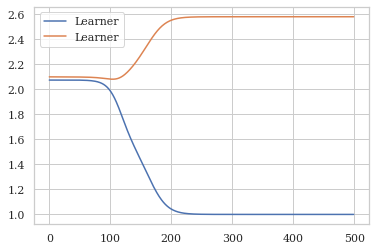

In [8]:
plt.plot(range(len(average_risks_learner)), average_risks_learner, label="Learner")
plt.legend()

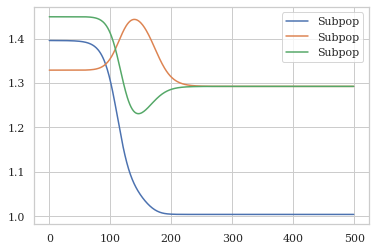

In [9]:
plt.plot(range(len(average_risks_subpop)), average_risks_subpop, label="Subpop")
plt.legend()